# LeNet5

[Paper here](https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)


In [1]:
from rich import print
from tqdm.notebook import tqdm
%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import mlflow

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.enable_system_metrics_logging()


In [4]:
# Hyperparameters

BATCH_SIZE = 128
N_EPOCHS = 10
LEARNING_RATE = 0.01
N_CLASSES = 10

## Load the dataset


In [5]:
train_dataset = MNIST(
    root="./data/", download=True, train=True, transform=transforms.ToTensor()
)
test_dataset = MNIST(
    root="./data/", download=True, train=False, transform=transforms.ToTensor()
)

mean_pixel_train, std_pixel_train = (
    train_dataset.data.float().mean() / 255,
    train_dataset.data.float().std() / 255,
)

mean_pixel_test, std_pixel_test = (
    test_dataset.data.float().mean() / 255,
    test_dataset.data.float().std() / 255,
)

In [6]:
train_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((mean_pixel_train,), (std_pixel_train,)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((mean_pixel_test,), (std_pixel_test,)),
    ]
)


In [7]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * std_pixel + mean_pixel

    x = transforms.ToPILImage()(x)

    return x

In [8]:
full_train_dataset = MNIST(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = MNIST(
    root="./data/", download=True, train=False, transform=test_transform
)


In [9]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


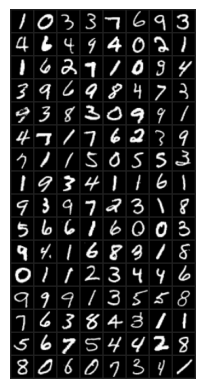

In [11]:
images, _ = next(iter(train_loader))

grid = make_grid(images, nrow=8)

plt.imshow(reverse_transform(grid, train=True))
plt.axis("off")
plt.show()

## Build the architecture


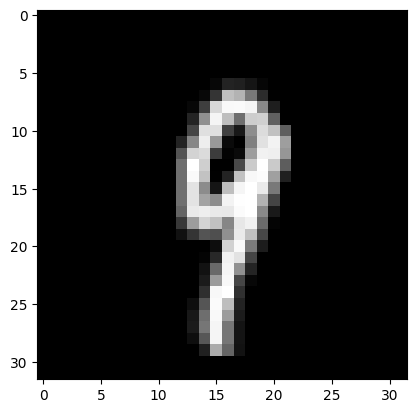

torch.Size([1, 32, 32])

9

In [12]:
sample_image, sample_label = train_loader.dataset[0]
plt.imshow(reverse_transform(sample_image), cmap="gray")
plt.show()
print(sample_image.shape)
print(sample_label)

In [21]:
class LeNet5(nn.Module):
    def __init__(self, n_classes: int = 10, debug: bool = False):
        super().__init__()
        self.debug = debug
        self.n_classes = n_classes

        # B x 1 x 32 x 32 -> B x 6 x 28 x 28
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0
        )
        # B x 6 x 28 x 28 -> B x 6 x 14 x 14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # B x 6 x 14 x 14 -> B x 16 x 10 x 10
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0
        )

        # B x 16 x 10 x 10 -> B x 16 x 5 x 5
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # B x 16 x 5 x 5 -> # B x 400
        self.flatten = nn.Flatten()

        # B x 400 -> # B x 120
        self.fc1 = nn.Linear(400, 120)

        # B x 120 -> # B x 84
        self.fc2 = nn.Linear(120, 84)

        # B x 84 -> # B x N_CLASSES
        self.fc3 = nn.Linear(84, self.n_classes)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._debug_print(x, "Input")
        x = F.tanh(self.conv1(x))
        self._debug_print(x, "Conv1")
        x = self.pool1(x)
        self._debug_print(x, "Pool1")
        x = F.tanh(self.conv2(x))
        self._debug_print(x, "Conv2")
        x = self.pool2(x)
        self._debug_print(x, "Pool2")
        x = self.flatten(x)
        self._debug_print(x, "Flatten")
        x = F.tanh(self.fc1(x))
        self._debug_print(x, "FC1")
        x = F.tanh(self.fc2(x))
        self._debug_print(x, "FC2")
        x = F.tanh(self.fc3(x))
        self._debug_print(x, "FC3")

        return x

In [22]:
model = LeNet5(debug=True)
x = model(sample_image.unsqueeze(1))


Input: torch.Size([1, 1, 32, 32])

Conv1: torch.Size([1, 6, 28, 28])

Pool1: torch.Size([1, 6, 14, 14])

Conv2: torch.Size([1, 16, 10, 10])

Pool2: torch.Size([1, 16, 5, 5])

Flatten: torch.Size([1, 400])

FC1: torch.Size([1, 120])

FC2: torch.Size([1, 84])

FC3: torch.Size([1, 10])

In [23]:
print(
    f"Total number of parameters in the model: {sum(p.numel() for p in model.parameters())}"
)


Total number of parameters in the model: 61706

## Train the model

In [24]:
model = LeNet5(n_classes=N_CLASSES, debug=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [26]:
mlflow.set_experiment(experiment_name="lenet5")

<Experiment: artifact_location='mlflow-artifacts:/135445217893204646', creation_time=1721227995909, experiment_id='135445217893204646', last_update_time=1721227995909, lifecycle_stage='active', name='lenet5', tags={}>

In [27]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    # Log hyperparameters
    mlflow.log_params(
        {
            "N_EPOCHS": N_EPOCHS,
            "LEARNING_RATE": LEARNING_RATE,
            "BATCH_SIZE": BATCH_SIZE,
            "Optimizer": optimizer.__class__.__name__,
            "Loss Function": criterion.__class__.__name__,
        }
    )

    for epoch in tqdm(range(N_EPOCHS)):
        # ---------- Training ----------
        train_loss = 0

        for batch, (inputs, labels) in enumerate(train_loader):
            model.train()

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        # ---------- Validation ----------

        val_loss = 0
        correct = 0
        total = 0
        model.eval()
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels)

                total += labels.size(0)
                correct += (labels == outputs.argmax(dim=-1)).sum().item()

            val_loss /= len(val_loader)
            val_acc = correct / total

        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)

    mlflow.pytorch.log_model(model, "model")


2024/07/17 11:21:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


  0%|          | 0/10 [00:00<?, ?it/s]

2024/07/17 11:25:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is

## Test the model

In [28]:
model.eval()

test_loss = 0
correct = 0
total = 0
with mlflow.start_run(run_id=run_id):
    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            test_loss += criterion(outputs, labels)

            total += labels.size(0)
            correct += (labels == outputs.argmax(dim=-1)).sum().item()

        test_loss /= len(test_loader)
        test_acc = correct / total

    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_acc", test_acc)

2024/07/17 11:25:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/17 11:25:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/17 11:25:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


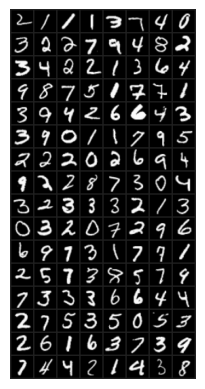

IndexPredictedActual

0    4    2

1    1    1

2    1    1

3    1    1

4    3    3

5    7    7

6    4    4

7    0    0

8    3    3

9    0    2

10   2    2

11   7    7

12   9    9

13   4    4

14   8    8

15   2    2

16   3    3

17   4    4

18   2    2

19   2    2

20   1    1

21   3    3

22   6    6

23   4    4

24   9    9

25   8    8

26   7    7

27   5    5

28   8    1

29   2    7

30   2    7

31   1    1

32   3    3

33   9    9

34   4    4

35   2    2

36   6    6

37   6    6

38   4    4

39   3    3

40   3    3

41   9    9

42   0    0

43   1    1

44   1    1

45   7    7

46   9    9

47   5    5

48   2    2

49   2    2

50   2    2

51   0    0

52   2    2

53   6    6

54   9    9

55   4    4

56   9    9

57   2    2

58   2    2

59   8    8

60   7    7

61   5    3

62   0    0

63   4    4

64   3    3

65   7    2

66   3    3

67   3    3

68   3    3

69   2    2

70   1    1

71   3    3

72   0    0

73   3    3

74   2    2

75   0    0

76   7    7

77   2    2

78   9    9

79   6    6

80   6    6

81   9    9

82   7    7

83   3    3

84   1    1

85   7    7

86   9    7

87   1    1

88   2    2

89   5    5

90   7    7

91   2    3

92   3    8

93   5    5

94   7    7

95   9    9

96   7    7

97   3    3

98   3    3

99   3    3

100  6    6

101  6    6

102  4    4

103  4    4

104  2    2

105  7    7

106  5    5

107  3    3

108  5    5

109  0    0

110  5    5

111  3    3

112  2    2

113  6    6

114  1    1

115  6    6

116  3    3

117  7    7

118  3    3

119  9    9

120  2    7

121  4    4

122  4    4

123  8    2

124  1    1

125  9    4

126  3    3

127  8    8

In [29]:
sample_test_images, sample_test_labels = next(iter(test_loader))

plt.imshow(reverse_transform(make_grid(sample_test_images)), cmap="gray")
plt.axis("off")
plt.show()

prediction = model(sample_test_images.to(device))

predicted_labels = prediction.argmax(dim=-1).cpu().numpy()
actual_labels = sample_test_labels.cpu().numpy()

print(f"{'Index':<5}{'Predicted':<5}{'Actual':<5}")
for i, (pred, actual) in enumerate(zip(predicted_labels, actual_labels)):
    print(f"{i:<5}{pred:<5}{actual:<5}", end="\n")
